Generate learning data (Euler truncation errors) from a single trajectory of the Van der Pol equation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import h5py

In [3]:
mu = 1.5
def vdp( t, x):
    y = np.empty(x.shape)
    y[0] = -mu*(x[1]*x[1]-1)*x[0]-x[1]
    y[1] = x[0]
    return y

end = 6
t = np.random.rand(1000)*end
t = np.sort(t)
sol = scipy.integrate.solve_ivp(vdp, [0, end], [1,1], t_eval=t, rtol=1e-10, atol=1e-10)

dydt = vdp(t, sol.y)

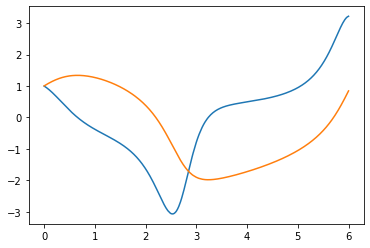

In [4]:
plt.figure(num="pl1")
plt.plot(sol.t,sol.y[0])
plt.plot(sol.t,sol.y[1])

In [5]:
np.savetxt("data/vdp_data_half_p.txt", np.column_stack((t, np.array(sol.y).T, dydt.T)))

Converting data and saving in hdf5 format

In [6]:
def euler_truncation_error(arr, output_size): 
    #t0 x1 x2 x3 z1 ... z8 dx1 dx2 dx3 dz1 ... dz8
    #0   1  2  3 4       11 12  13  14  15      22
    dt = arr[1:,0] - arr[:-1,0]
    X = np.column_stack((arr[1:,0], arr[:-1,:1+output_size])) #t1 t0 x1(0) x2(0) x3(0) z(0)
    dt_m = np.copy(dt)
    for n in range(1,output_size):
        dt_m = np.column_stack((dt_m,dt))
    Y = np.reciprocal(dt_m*dt_m)*(arr[1:,1:output_size+1] - arr[:-1,1:output_size+1] - dt_m*arr[:-1, output_size+1:])
    return X,Y

In [7]:
path_to_hdf = 'data/vdp_data_half_p.hdf5'
path_to_txt = 'data/vdp_data_half_p.txt'

arr = np.loadtxt(path_to_txt, dtype=np.float64, delimiter=' ')

dt = True #whether to use absolute time or time steps
l = arr.shape[0]
b = 1
n = 1000
sum = 0
for i in range(b,n):
    sum = sum + l - i - 1

with h5py.File(path_to_hdf, 'a') as f:
    f.create_dataset(
        str('vdp_X'),
        (sum,3 if dt else 4),
        dtype   = np.float64,
        compression     = 'gzip',
        compression_opts= 6
        )
    f.create_dataset(
        str('vdp_Y'),
        (sum,2),
        dtype   = np.float64,
        compression     = 'gzip',
        compression_opts= 6
        )
    begin = 0
    end = l-1
    X = f['vdp_X']
    Y = f['vdp_Y']
    x,y = euler_truncation_error(np.copy(arr[:][0::b]),2)
    if dt: 
        x = np.column_stack((x[:,0] - x[:,1],x[:,2],x[:,3]))
    X[begin:end,:] = x
    Y[begin:end,:] = y
    for i in range(b+1,n):
        for j in range(i):
            x,y = euler_truncation_error(np.copy(arr[:][j::i]), 2)
            if dt: 
                x = np.column_stack((x[:,0] - x[:,1],x[:,2],x[:,3]))
            begin = end
            end = begin+x.shape[0]
            X[begin:end,:] = x
            Y[begin:end,:] = y
        